In [1]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from collections import OrderedDict
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import Isomap
import time

%matplotlib inline

In [2]:
geonames = pd.read_pickle("../../../../dosT/ffunes/geonames_parsed.pkl")

from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_distance(row):
    predicted_lat = row['predicted_lat']
    predicted_lon = row['predicted_lon']
    real_lat = row['real_lat']
    real_long = row['real_lon']
    
    return haversine_distance(predicted_lat, predicted_lon, real_lat, real_long)

def get_difference_distance(predicted_place, real_place):
    df_prediction = pd.DataFrame({
        'predicted_place': predicted_place,
        'real_place': real_place
    }, dtype=float)
        
    df_prediction[['predicted_cities','predicted_countries']] = df_prediction.predicted_place.str.split(',', expand=True) 
    df_prediction[['real_cities','real_countries']] = df_prediction.real_place.str.split(',', expand=True) 
    
    del df_prediction['predicted_place']
    del df_prediction['real_place']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['predicted_cities', 'predicted_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    df_prediction.rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'}, inplace=True)
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['real_cities', 'real_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction.rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'}, inplace=True)
    
    #print(df_prediction.head(5))
    
    print("Total NaN: ", df_prediction.shape[0]-df_prediction.dropna(subset=['real_lat', 'real_lon', 'predicted_lat', 'predicted_lon']).shape[0])

    return df_prediction.apply(determine_distance, axis=1)

In [3]:
users_with_followers_ = pd.read_pickle("../../../../dosT/ffunes/users_with_followers.pkl")

In [4]:
lst_col = 'followee_id'
users_with_followers_ = pd.DataFrame({
          col:np.repeat(users_with_followers_[col].values, users_with_followers_[lst_col].str.len())
          for col in users_with_followers_.columns.difference([lst_col])
      }).assign(**{lst_col:np.concatenate(users_with_followers_[lst_col].values)})[users_with_followers_.columns.tolist()]

In [5]:
followers_count = users_with_followers_.loc[:,['id', 'followee_id']].\
    drop_duplicates().groupby('followee_id').count()

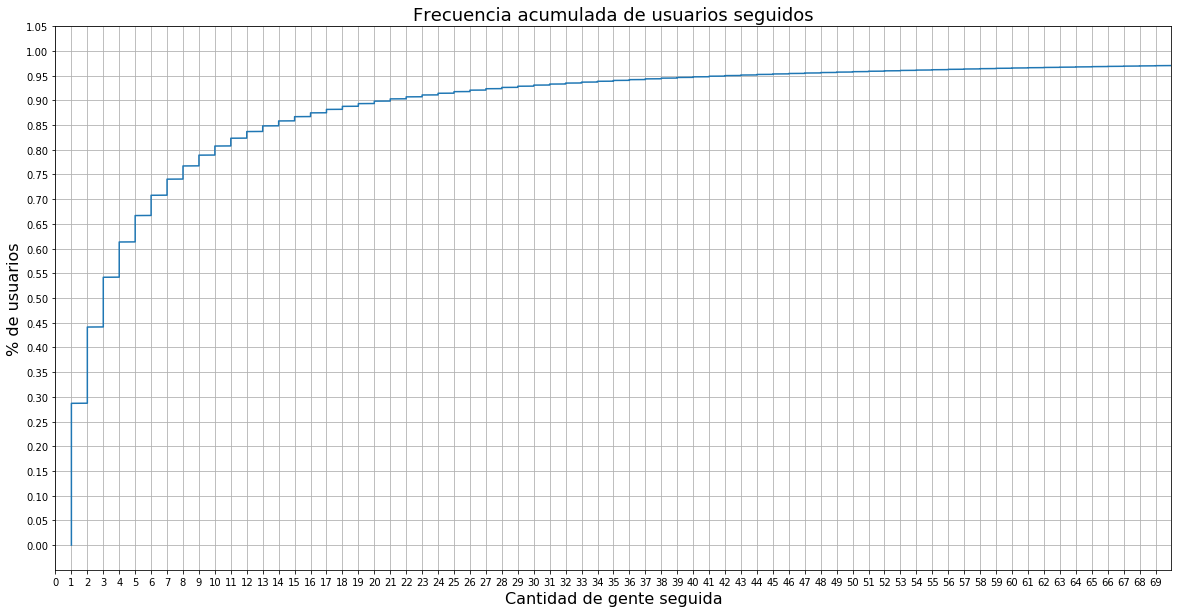

In [6]:
ecdf = ECDF(followers_count["id"])

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Cantidad de gente seguida", fontsize=16)
plt.ylabel("% de usuarios", fontsize=16)
plt.title("Frecuencia acumulada de usuarios seguidos", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.05))
plt.xticks(np.arange(0,70,1))
plt.xlim(0, 70)
#plt.hlines(accuracy_score(y_test[:, 0], y_predicted_city), -200, 1000, colors='r', linestyles='dashed')
#plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [7]:
usecols = [
    "id",
    "place_name",
    "place_country",
    "latitude",
    "longitude"
]

users = pd.read_pickle("../../../../dosT/ffunes/total_users_parsed.pkl")
users = users.loc[:, usecols]

print(users.shape)

users["unified_place"] = users["place_name"] + ',' + users["place_country"]

min_determined_place = users.loc[:, ["id", "unified_place"]].groupby("unified_place").count().sort_values('id', ascending=False).reset_index()

min_determined_place = min_determined_place.loc[min_determined_place["id"] >= 1170, :]

users = pd.merge(
    left=users,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)

del users["place_name"]
del users["place_country"]

TOTAL_USERS = users.shape[0]

(176029, 5)


In [8]:
TOTAL_USERS

80812

In [8]:
users_with_followers_["unified_place"] = users_with_followers_["place_name"] + ',' + users_with_followers_["place_country"]
users_with_followers_.rename(columns={"id": "user_id"}, inplace=True)


users_with_followers_ = pd.merge(
    left=users_with_followers_,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)

In [9]:
import re
def extract_oslom(filename):
    """Funcion que extrae las comunidades detectadas por OSLOM a las que pertence un vertice de la red."""
    clusters = {}
    hashtag_clusters = {}
    data = []
    with open(filename) as f:
        cluster = ""
        for line in f:
            m = re.search("^#module\s([0-9]+).*", line)
            #print line
            if (m is not None):
                cluster = int(m.group(1))
            else:
                l = line.replace('\n', ' ').strip().split(" ")
                l = list(map(int, l))
                clusters[cluster] = l
                for i in l:
                    if not i in hashtag_clusters:
                        hashtag_clusters[i] = set()
                    hashtag_clusters[i].add(cluster)
                    data.append([i, cluster])
    return pd.DataFrame(data=data, columns=["user_id", "cluster"]), hashtag_clusters

In [10]:
values_sample = np.unique(np.logspace(0, 4, num=40, dtype="int"))
values_sample

array([    1,     2,     3,     4,     5,     6,     8,    10,    13,
          17,    21,    27,    34,    43,    55,    70,    88,   112,
         142,   180,   228,   289,   366,   464,   587,   744,   942,
        1193,  1511,  1914,  2424,  3070,  3888,  4923,  6235,  7896,
       10000])

In [11]:
#Logistic regression

df_final = pd.DataFrame(columns=[
    "total_users", 
    "users_filtered",
    "users_to_train",
    "mean_accuracy_train",
    "mean_accuracy_test",
    "mean_balanced_accuracy_test",
    "mean_accuracy_100km",
    "mean_accuracy_161km",
    "max_accuracy_train",
    "max_accuracy_test",
    "max_balanced_accuracy_test",
    "max_accuracy_100km",
    "max_accuracy_161km",    
    "minimum_user_followers"
    ])

iteration = 0
start = time.time()
for min_followers in values_sample:
    print("Start iteration {}".format(iteration))

    count = followers_count.reset_index()
    
    lim_followers_users = count.loc[
        ((count["id"] >= min_followers)),
        ["followee_id"]
    ]
    
    users_with_followers = pd.merge(
        left=users_with_followers_,
        right=lim_followers_users,
        how='inner',
        left_on=["followee_id"],
        right_on=["followee_id"],
        validate="m:1" 
    )
    
    '''users_with_mentions = pd.merge(
        left=users,
        right=tweets_with_mentions_limit.loc[:, ["user_mentioned", "user_id"]],
        how='inner',
        left_on=["id"],
        right_on=["user_id"],
        validate="1:m" 
    )
    
    del users_with_mentions["id"]'''
    
    print("Users filtered")
    
    if users_with_followers.shape[0] == 0:
        print("No more users")
        break
    
    users_with_followers = users_with_followers.groupby(
        ["user_id", "unified_place", "latitude", "longitude"]
    )['followee_id'].apply(list).reset_index(name='followers')
    
    USERS_FILTERED = users_with_followers.shape[0]
    
    users_with_followers["followers"] = users_with_followers["followers"].apply(lambda l: list(map(str, l)))
    users_with_followers["user_id"] = users_with_followers["user_id"].apply(lambda l: str(l))
    
    users_with_followers.loc[:, ['followers']] = users_with_followers["followers"].apply(lambda l: list(map(str, l)))
        
    users_train_selected = users_with_followers
        
    users_ids = users_train_selected["user_id"].apply(lambda l: str(l)).values
    
    a = set()
    
    for x in users_train_selected["followers"].values:
        for val in x:
            a.add(str(val))

    all_users_mentioned = list(a)
    
    total_users = np.concatenate([users_ids, all_users_mentioned])
    
    a = OrderedDict.fromkeys(total_users)
    
    total_users = list(a)
    
    vectorizer = CountVectorizer(
        strip_accents="ascii",
        lowercase=False,
        vocabulary=total_users,
        token_pattern=r"(?u)\b\w+\b"
    )
    
    print("Using {} users".format(users_train_selected.shape[0]))

    vector_of_followers = vectorizer.fit_transform(users_train_selected["followers"].apply(lambda x: ' '.join(x))).astype('int')
    
    print("Vector of followers built")
    
    cx = vector_of_followers.tocoo()
    edges = []
    checker = list(range(users_train_selected.shape[0]))

    for i,j,v in zip(cx.row, cx.col, cx.data):
        #format_str = users_ids[i] + " " + users_ids[j] + " " + str(v)
        format_str = str(i) + " " + str(j) + " " + str(v)
        edges.append(format_str)
        
    df = pd.DataFrame({"edges": edges})
    df.to_csv("../results/tmp/edges_followers_weighted_test.csv", header=False, index=False)
    
    print("Edges stored in disk")
    print("Starting Oslom")
    
    scores_train = []
    scores_test = []
    balanced_scores = []
    scores_100km = []
    scores_161km = []
    
    for l in range(0, 1):
        !cd ../oslom/OSLOM2 && \
        ./oslom_dir -f ../../results/tmp/edges_followers_weighted_test.csv -w -fast -seed 430430 -cp 0.5

        print("Oslom ended, starting predictions")

        train, clusters = extract_oslom('../results/tmp/edges_followers_weighted_test.csv_oslo_files/tp')
        
        def get_original_user_id(row):
            return total_users[row["user_id"]]

        #communities_infomap["real_user_id"] = communities_infomap.apply(get_original_user_id, axis=1)
        train["real_user_id"] = train.apply(get_original_user_id, axis=1)
        
        train = train.astype({'real_user_id': 'int64'})
        
        users_train_final = pd.merge(
            left=train,
            #right=users_train_selected,
            right=users,
            how='inner',
            left_on="real_user_id",
            #right_on="user_id",
            right_on="id",
            validate="m:1"
        )
        
        USERS_TOTAL_TRAIN = users_train_final.shape[0]
  
        users_train_final = users_train_final.loc[:, ["real_user_id", "cluster", "unified_place", "latitude", "longitude"]]
        
        users_train_final = users_train_final.groupby(
            ["real_user_id", "unified_place", "latitude", "longitude"]
        )['cluster'].apply(list).reset_index(name='clusters')
        
        users_train_final = users_train_final.sample(frac=1, random_state=4503493)
        users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
        class_names = sorted(users_train_final['unified_place'].unique())
                
        #users_train_final = users_train_final.loc[:, ["k"]]
        users_train_final = users_train_final.loc[:, ["clusters"]]
        
        users_train_final["clusters"] = users_train_final["clusters"].apply(lambda l: list(map(str, l)))

        vectorizer = CountVectorizer(
            strip_accents="ascii",
            lowercase=False,
            token_pattern=r"(?u)\b\w+\b"
        )
        
        print(users_train_final.head())

        vector_of_clusters = vectorizer.fit_transform(users_train_final["clusters"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
        vector_of_clusters        
        
        print("Data prepared for training")
        
        #X_train, X_test, y_train, y_test = train_test_split(users_train_final, users_complete_location[:,0], test_size=0.30)

        #decisiontree = DecisionTreeClassifier()
        decisiontree = RandomForestClassifier(n_jobs=2)
        decisiontree.get_params()
        
        X_train, X_test, y_train, y_test = train_test_split(vector_of_clusters, users_complete_location[:,0], test_size=0.30)
        
        print("Starting train")

        param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
                 'class_weight': ['balanced']}
        grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
        grid_drop.fit(X_train, y_train)

        #BEST_SCORE_TRAIN = grid_drop.best_score_
        scores_train.append(grid_drop.best_score_)
        
        y_predicted = grid_drop.predict(X_test)

        #BEST_SCORE_TEST = accuracy_score(y_test, y_predicted)
        
        scores_test.append(accuracy_score(y_test, y_predicted))

        #BALANCED_SCORE = balanced_accuracy_score(y_test, y_predicted)
        
        balanced_scores.append(balanced_accuracy_score(y_test, y_predicted))
        
        distances_predicted = get_difference_distance(
            y_predicted,
            y_test
        )

        scores_100km.append(distances_predicted[distances_predicted <= 100].shape[0]/distances_predicted.shape[0])
        scores_161km.append(distances_predicted[distances_predicted <= 161].shape[0]/distances_predicted.shape[0])

    MEAN_SCORE_TRAIN = np.mean(scores_train)
    MEAN_SCORE_TEST = np.mean(scores_test)
    MEAN_BALANCED_SCORE = np.mean(balanced_scores)
    MEAN_ACCURACY_100km = np.mean(scores_100km)
    MEAN_ACCURACY_161km = np.mean(scores_161km)
    
    MAX_SCORE_TRAIN = np.max(scores_train)
    MAX_SCORE_TEST = np.max(scores_test)
    MAX_BALANCED_SCORE = np.max(balanced_scores)
    MAX_ACCURACY_100km = np.max(scores_100km)
    MAX_ACCURACY_161km = np.max(scores_161km)
    
    df_final.loc[iteration] = [
        TOTAL_USERS,
        USERS_FILTERED,
        USERS_TOTAL_TRAIN,
        MEAN_SCORE_TRAIN,
        MEAN_SCORE_TEST,
        MEAN_BALANCED_SCORE,
        MEAN_ACCURACY_100km,
        MEAN_ACCURACY_161km,
        MAX_SCORE_TRAIN,
        MAX_SCORE_TEST,
        MAX_BALANCED_SCORE,
        MAX_ACCURACY_100km,
        MAX_ACCURACY_161km,
        min_followers
    ]

    iteration += 1
    
    print("Iteration end")
    print("--------------------------")
    df_final.to_csv("../results/tmp/results_test_min_followers_oslom_tmp.csv", index=False)
    
df_final.to_csv("../results/followers/results_test_min_followers_oslom_random_forest_all_users.csv", index=False)

end = time.time()

Start iteration 0
Users filtered
Using 29475 users
Vector of followers built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_followers_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 5181394 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 506285 nodes and 5.18139e+06 stubs;	 average degree = 10.2341
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 25508
iteration: 20 number of modules: 6180
collection done 


chec

minimality check: 9 modules to check, run: 2
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 15162
collection done 


possible fusions to check: 14175
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 1
checked 700 unions. Fused: 1
checked 800 unions. Fused: 2
checked 900 unions. Fused: 2
checked 1000 unions. Fused: 2
checked 1100 unions. Fused: 2
checked 1200 unions. Fused: 2
checked 1300 unions. Fused: 2
checked 1400 unions. Fused: 2
checked 1500 unions. Fused: 2
checked 1700 unions. Fused: 2
checked 1900 unions. Fused: 2
checked 2300 unions. Fused: 2
checked 2500 unions. Fused: 2
checked 2700 unions. Fused: 2
checked 2800 unions. Fused: 2
checked 3400 unions. Fused: 2
checked 4100 u

Oslom ended, starting predictions
         clusters
29945       [969]
13482  [470, 905]
16071      [1147]
38431       [855]
22178       [840]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 1
Users filtered
Using 29475 users
Vector of followers built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_followers_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 5085070 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 411087 nodes and 5.08507e+06

pairs to check: 131
pairs to check: 114
pairs to check: 111
minimality check: 7 modules to check, run: 1
pairs to check: 37
pairs to check: 35
minimality check: 28 modules to check, run: 1
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1173 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/partitions_level_0
1173 groups found
1173 bss found
checking homeless nodes
assigning homeless nodes. Homeless at this point: 272212
assigning homeless nodes. Homeless at this point: 9168
assigning homeless nodes. Homeless at this point: 14
assigning homeless nodes. Homeless at this point: 2
writing final solution in file ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/tp
******** module_collection ******** 1173 modules. writing..

checked 1200 modules 1184 were found significant.  Modules to check: 1578. Percentage nodes done: 0.929256
checked 1300 modules 1279 were found significant.  Modules to check: 1478. Percentage nodes done: 0.935896
checked 1400 modules 1378 were found significant.  Modules to check: 1378. Percentage nodes done: 0.943953
checked 1500 modules 1475 were found significant.  Modules to check: 1278. Percentage nodes done: 0.950283
checked 1600 modules 1573 were found significant.  Modules to check: 1178. Percentage nodes done: 0.956161
checked 1700 modules 1672 were found significant.  Modules to check: 1078. Percentage nodes done: 0.961595
checked 1800 modules 1769 were found significant.  Modules to check: 978. Percentage nodes done: 0.966797
checked 1900 modules 1866 were found significant.  Modules to check: 878. Percentage nodes done: 0.971174
checked 2000 modules 1963 were found significant.  Modules to check: 778. Percentage nodes done: 0.975522
checked 2100 modules 2062 were found sig

network:: 16 nodes and 7433 stubs;	 average degree = 464.562
STARTING! HIERARCHICAL LEVEL: 4
***************************************************************** RUN: #1
iteration: 0 number of modules: 5
collection done 


checked 0 modules 0 were found significant.  Modules to check: 3. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 3
iteration: 0 number of modules: 2
collection done 


checking unions of not significant modules, modules to check: 1
iteration: 0 number of modules: 1
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
pruning all the modules collected. Partitions found:

iteration: 0 number of modules: 129
iteration: 20 number of modules: 23
collection done 


possible fusions to check: 23
checked 0 unions. Fused: 1
check unions of modules using community network

iteration: 0 number of modules: 14
collection done 


possible fusions to check: 6
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 20 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/partitions_level_1
20 groups found
20 bss found
checking homeless nodes
writing final solution in file ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/short_tp1
******** module_collection ******** 20 modules. writing... 
DONE   ****************************
netwo

DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/partitions_level_0
729 groups found
729 bss found
checking homeless nodes
assigning homeless nodes. Homeless at this point: 106998
assigning homeless nodes. Homeless at this point: 1708
writing final solution in file ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/tp
******** module_collection ******** 729 modules. writing... 
DONE   ****************************
network:: 729 nodes and 2.31608e+06 stubs;	 average degree = 3177.06
STARTING! HIERARCHICAL LEVEL: 1
***************************************************************** RUN: #1
iteration: 0 number of modules: 186
collection done 


checked 0 modules 0 were found significant.  Modules to check: 127. Percentage nodes done: 0
checked 100 modules 100 were found significant.  Modules to check: 27. Percentage nodes done: 0.897119
signific

check unions of modules using community network

iteration: 0 number of modules: 1709
collection done 


possible fusions to check: 1158
checked 0 unions. Fused: 0
checked 100 unions. Fused: 14
checked 200 unions. Fused: 50
checked 300 unions. Fused: 73
checked 400 unions. Fused: 82
checked 600 unions. Fused: 84
check unions of modules using community network

iteration: 0 number of modules: 1690
iteration: 20 number of modules: 1115
collection done 


possible fusions to check: 1123
checked 0 unions. Fused: 0
checked 100 unions. Fused: 9
checked 200 unions. Fused: 27
checked 300 unions. Fused: 40
checked 400 unions. Fused: 58
checking highly intersecting modules

pairs to check: 488
pairs to check: 125
minimality check: 7 modules to check, run: 1
pairs to check: 15
pairs to check: 10
pairs to check: 3
pairs to check: 3
pairs to check: 3
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 

iteration: 0 number of modules: 6
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 620 modules to check, run: 0
minimality check: 51 modules to check, run: 1
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 1305
collection done 


possible fusions to check: 822
checked 0 unions. Fused: 0
checked 100 unions. Fused: 27
checked 200 unions. Fused: 71
check unions of modules using community network

iteration: 0 number of modules: 1286
iteration: 20 number of modules: 833
collection done 


possible fusions to check: 834
checked 0 unions. Fused: 0
checked 100 unions. Fused: 19
checked 200 unions. Fused: 44
checked 800 unions. Fused: 69
checking highly intersecting modules

pairs to check:

iteration: 0 number of modules: 4
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 467 modules to check, run: 0
minimality check: 84 modules to check, run: 1
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 739
collection done 


possible fusions to check: 307
checked 0 unions. Fused: 0
checked 100 unions. Fused: 32
checked 200 unions. Fused: 52
check unions of modules using community network

iteration: 0 number of modules: 736
iteration: 20 number of modules: 287
collection done 


possible fusions to check: 288
checked 0 unions. Fused: 0
checked 100 unions. Fused: 28
checked 200 unions. Fused: 53
checking highly intersecting modules

pairs to check: 218
pairs to check: 52
pairs to

minimality check: 142 modules to check, run: 1
minimality check: 6 modules to check, run: 2
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 773
collection done 


possible fusions to check: 191
checked 0 unions. Fused: 0
checked 100 unions. Fused: 25
check unions of modules using community network

iteration: 0 number of modules: 774
iteration: 20 number of modules: 170
collection done 


possible fusions to check: 171
checked 0 unions. Fused: 0
checked 100 unions. Fused: 20
checking highly intersecting modules

pairs to check: 267
pairs to check: 82
pairs to check: 42
pairs to check: 34
pairs to check: 29
pairs to check: 27
pairs to check: 28
pairs to check: 26
pairs to check: 25
pairs to check: 23
pairs to check: 18
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
*

iteration: 0 number of modules: 615
iteration: 20 number of modules: 116
collection done 


possible fusions to check: 117
checked 0 unions. Fused: 0
checked 100 unions. Fused: 9
check unions of modules using community network

iteration: 0 number of modules: 605
collection done 


possible fusions to check: 119
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 239
pairs to check: 35
pairs to check: 19
pairs to check: 8
pairs to check: 3
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 353 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/partitions_level_0
353 groups found
353 bss found
checking homeless nodes
assigning homeless nodes. Homeless at this point: 21969
assigning homeless nodes. Homeless a

checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 7
collection done 


possible fusions to check: 2
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 6 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/partitions_level_1
6 groups found
6 bss found
checking homeless nodes
writing final solution in file ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/short_tp1
******** module_collection ******** 6 modules. writing... 
DONE   ****************************
network:: 6 nodes and 118225 stubs;	 average degree = 19704.2
STARTING! HIERARCHICAL LEVEL: 2
*************************************

Oslom ended, starting predictions
      clusters
11462    [205]
26753    [208]
5582     [196]
926       [81]
15554    [221]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 12
Users filtered
Using 29437 users
Vector of followers built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_followers_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 3550715 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 66127 nodes and 3.55072e+06 stubs;	 average d

allocating 3379349 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 58309 nodes and 3.37935e+06 stubs;	 average degree = 57.9559
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 5874
iteration: 20 number of modules: 92
collection done 


checked 0 modules 0 were found significant.  Modules to check: 105. Percentage nodes done: 0
checked 100 modules 87 were found significant.  Modules to check: 5. Percentage nodes done: 0.998319
significance check done 


checking unions of not significant modules, modules to check: 13
iteration: 0 number of modules: 13
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING 

186 groups found
186 bss found
checking homeless nodes
assigning homeless nodes. Homeless at this point: 8218
assigning homeless nodes. Homeless at this point: 39
writing final solution in file ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/tp
******** module_collection ******** 186 modules. writing... 
DONE   ****************************
network:: 186 nodes and 2.22313e+06 stubs;	 average degree = 11952.3
STARTING! HIERARCHICAL LEVEL: 1
***************************************************************** RUN: #1
iteration: 0 number of modules: 33
collection done 


checked 0 modules 0 were found significant.  Modules to check: 29. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check u

writing final solution in file ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/short_tp1
******** module_collection ******** 6 modules. writing... 
DONE   ****************************
network:: 6 nodes and 118318 stubs;	 average degree = 19719.7
STARTING! HIERARCHICAL LEVEL: 2
***************************************************************** RUN: #1
iteration: 0 number of modules: 2
collection done 


checked 0 modules 0 were found significant.  Modules to check: 1. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 1
iteration: 0 number of modules: 1
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
***************************************************************************
CHECK U

Oslom ended, starting predictions
      clusters
27720    [132]
21363    [132]
9986      [58]
25101     [15]
873      [132]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 17
Users filtered
Using 29398 users
Vector of followers built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_followers_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 2611167 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 39579 nodes and 2.61117e+06 stubs;	 average d

allocating 2405783 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 37093 nodes and 2.40578e+06 stubs;	 average degree = 64.8581
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 2972
iteration: 20 number of modules: 38
collection done 


checked 0 modules 0 were found significant.  Modules to check: 41. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 3
iteration: 0 number of modules: 3
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 37 modules to check, run: 0
minimality check: 59 modules to 

network:: 81 nodes and 1.42087e+06 stubs;	 average degree = 17541.6
STARTING! HIERARCHICAL LEVEL: 1
***************************************************************** RUN: #1
iteration: 0 number of modules: 13
collection done 


checked 0 modules 0 were found significant.  Modules to check: 12. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 5
collection done 


possible fusions to check: 4
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 2
collection done 


possible fusions to check: 2
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to ch

Oslom ended, starting predictions
      clusters
7462      [71]
24337     [19]
5070      [18]
19273     [71]
27788     [47]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 21
Users filtered
Using 29350 users
Vector of followers built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_followers_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 1789159 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 32494 nodes and 1.78916e+06 stubs;	 average d

DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/partitions_level_0
42 groups found
42 bss found
checking homeless nodes
assigning homeless nodes. Homeless at this point: 6153
assigning homeless nodes. Homeless at this point: 10
writing final solution in file ../../results/tmp/edges_followers_weighted_test.csv_oslo_files/tp
******** module_collection ******** 42 modules. writing... 
DONE   ****************************
network:: 42 nodes and 952490 stubs;	 average degree = 22678.3
STARTING! HIERARCHICAL LEVEL: 1
***************************************************************** RUN: #1
iteration: 0 number of modules: 8
collection done 


checked 0 modules 0 were found significant.  Modules to check: 8. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


**************************************************

Oslom ended, starting predictions
      clusters
26182      [4]
27880      [1]
7033       [4]
9169      [29]
19064     [11]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 24
Users filtered
Using 29295 users
Vector of followers built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_followers_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 1356452 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 30709 nodes and 1.35645e+06 stubs;	 average d

Oslom ended, starting predictions
      clusters
15456      [1]
10368      [0]
26749      [8]
11886      [9]
16964      [1]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 26
Users filtered
Using 29234 users
Vector of followers built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_followers_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 1095767 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 30079 nodes and 1.09577e+06 stubs;	 average d

Oslom ended, starting predictions
      clusters
6455       [0]
25573      [1]
24364      [1]
21607      [0]
29085      [2]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 28
Users filtered
Using 29164 users
Vector of followers built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_followers_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 857760 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 29655 nodes and 857760 stubs;	 average degree 

Oslom ended, starting predictions
      clusters
19361      [5]
20373      [7]
28629      [2]
20526      [0]
22945      [4]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 30
Users filtered
Using 28997 users
Vector of followers built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_followers_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 574895 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 29209 nodes and 574895 stubs;	 average degree 

Oslom ended, starting predictions
      clusters
2838       [1]
12336      [3]
1349       [3]
16851      [1]
945        [3]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 32
Users filtered
Using 28688 users
Vector of followers built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_followers_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 315429 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 28770 nodes and 315429 stubs;	 average degree 

allocating 154004 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_followers_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_followers_weighted_test.csv_oslo_files
network:: 27857 nodes and 154004 stubs;	 average degree = 5.52838
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 37
collection done 


checked 0 modules 0 were found significant.  Modules to check: 10. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 1
iteration: 0 number of modules: 1
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

In [ ]:
print((end - start)/60/60)

In [3]:
df_final = pd.read_csv("../results/followers/results_test_min_followers_oslom_random_forest_all_users.csv")
df_final.head()

,total_users,users_filtered,users_to_train,mean_accuracy_train,mean_accuracy_test,mean_balanced_accuracy_test,mean_accuracy_100km,mean_accuracy_161km,max_accuracy_train,max_accuracy_test,max_balanced_accuracy_test,max_accuracy_100km,max_accuracy_161km,minimum_user_followers
0,80812.0,29475.0,46340.0,0.450251,0.462727,0.455441,0.706383,0.706383,0.450251,0.462727,0.455441,0.706383,0.706383,1.0
1,80812.0,29475.0,42417.0,0.438126,0.452937,0.524208,0.721831,0.721831,0.438126,0.452937,0.524208,0.721831,0.721831,2.0
2,80812.0,29475.0,38837.0,0.399866,0.411608,0.499501,0.705666,0.705666,0.399866,0.411608,0.499501,0.705666,0.705666,3.0
3,80812.0,29474.0,36475.0,0.425715,0.415145,0.496362,0.682990,0.682990,0.425715,0.415145,0.496362,0.682990,0.682990,4.0
4,80812.0,29474.0,34916.0,0.413985,0.418374,0.497163,0.710487,0.710487,0.413985,0.418374,0.497163,0.710487,0.710487,5.0


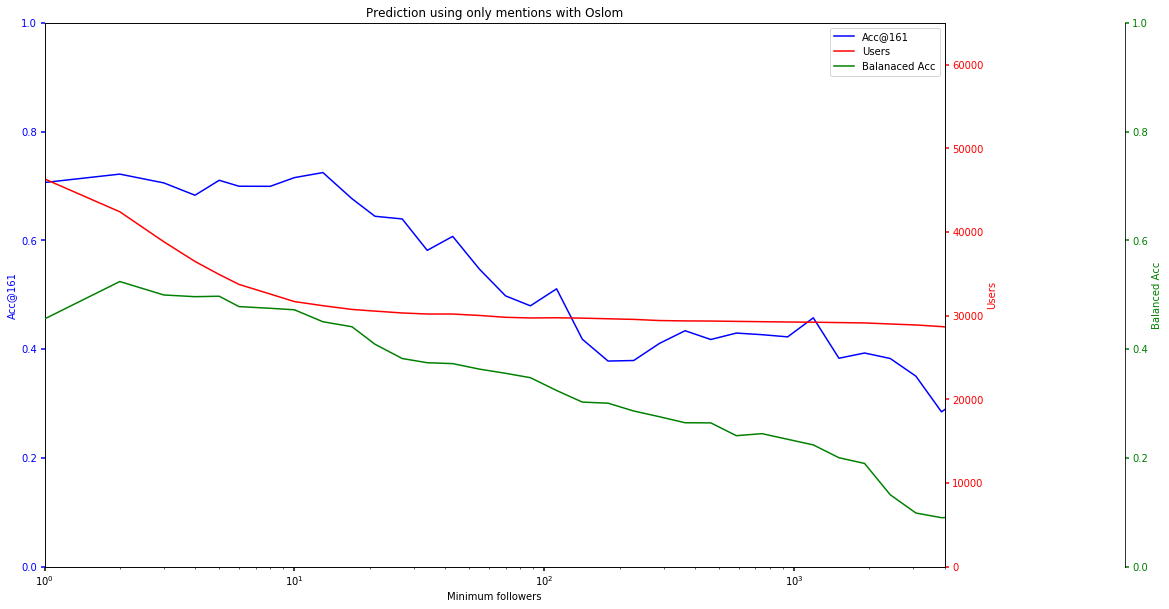

In [4]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
fig, host = plt.subplots(figsize=(20,10))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(df_final["minimum_user_followers"].values, df_final["mean_accuracy_161km"].values, "b-", label="Acc@161")
#p2, = par1.plot(df_final["minimum_user_followers"].values, df_final["users_filtered"].values, "r-", label="Users")
p2, = par1.plot(df_final["minimum_user_followers"].values, df_final["users_to_train"].values, "r-", label="Users")
p3, = par2.plot(df_final["minimum_user_followers"].values, df_final["mean_balanced_accuracy_test"].values, "g-", label="Balanaced Acc")

host.set_xscale('log')

host.set_xlim(1, 4000)
host.set_ylim(0, 1.0)
par1.set_ylim(0, 65000)
par2.set_ylim(0, 1.0)

host.set_xlabel("Minimum followers")
host.set_ylabel("Acc@161")
par1.set_ylabel("Users")
par2.set_ylabel("Balanced Acc")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines])

plt.title("Prediction using only mentions with Oslom")
plt.show()